In [ ]:
# COLAB VERSION

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import math
import osmnx as ox
from shapely.ops import unary_union
import contextily as cx
from summarytools import dfSummary
import ipywidgets as widgets
from IPython.display import display
import uuid
import pycountry
import os

In [ ]:
# from google.colab import data_table

In [ ]:
fetch_data = False

## Get country boundaries

In [ ]:
un_boundaries = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/country_boundary_data/boundaries.geojson")
algeria = un_boundaries[un_boundaries.romnam == "Algeria"]

<Axes: >

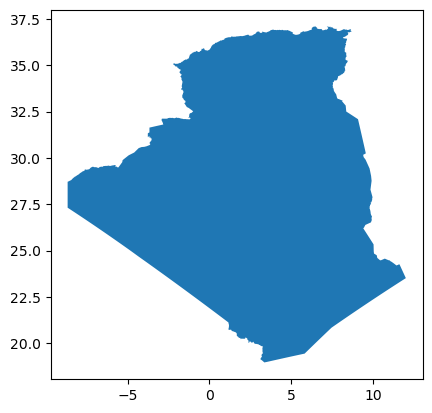

In [ ]:
algeria.plot()

In [ ]:
algeria_boundary = algeria.total_bounds
algeria_utm = algeria.estimate_utm_crs()
algeria_latitude = algeria.centroid.y.squeeze()

/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_46689/4143853990.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  algeria_latitude = algeria.centroid.y.squeeze()


In [ ]:
def get_iso3_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_3
    except AttributeError:
        return None

In [ ]:
algeria_iso3 = get_iso3_country_code("Algeria")
print(f"The ISO3 code for Algeria is {algeria_iso3}")

The ISO3 code for Algeria is DZA


## Get point of interest (POI) data

In [ ]:
if fetch_data:
    place = "Algeria"
    tags = {"amenity": "school"}
    algeria_schools_gdf = ox.features_from_place(place, tags)
else:
    algeria_schools_gdf = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-schools.geojson")

In [ ]:
algeria_schools_gdf = algeria_schools_gdf[["osmid","amenity","element_type","addr:city","isced:level","operator", "geometry"]]

## Get Ookla data

In [ ]:
def get_perf_tiles_parquet_url(service: str, year: int, quarter: int) -> str:
    quarter_start = f"{year}-{(((quarter - 1) * 3) + 1):02}-01"
    url = f"s3://ookla-open-data/parquet/performance/type={service}/year={year}/quarter={quarter}/{quarter_start}_performance_{service}_tiles.parquet"
    return url

### Mobile

In [ ]:
if fetch_data:
    mobile_perf_tiles_url = get_perf_tiles_parquet_url("mobile", 2024, 2)
    bbox_filters = [('tile_y', '<=', algeria_boundary[3]), ('tile_y', '>=', algeria_boundary[1]),
                ('tile_x', '<=', algeria_boundary[2]), ('tile_x', '>=', algeria_boundary[0])]
    mobile_tiles_df = pd.read_parquet(mobile_perf_tiles_url,
                           filters=bbox_filters,
                           columns=['tile_x', 'tile_y', 'tests', 'avg_d_kbps', 'avg_lat_ms'],
                           storage_options={"s3": {"anon": True}}
                           )
else:
    mobile_tiles_df = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-ookla-mobile-tiles.csv",index_col=0)

In [ ]:
mobile_tiles_gdf = gpd.GeoDataFrame(mobile_tiles_df, geometry=gpd.points_from_xy(mobile_tiles_df.tile_x, mobile_tiles_df.tile_y), crs="EPSG:4326").drop(columns=["tile_x", "tile_y"])

#### Generate mobile coverage area

In [ ]:
tile_size_at_latitude=610.8*np.cos(math.radians(algeria_latitude))
buffers = mobile_tiles_gdf.to_crs(algeria_utm).buffer(tile_size_at_latitude).to_crs("EPSG:4326")
single_polygon = unary_union(buffers)
algeria_mobile_coverage_gdf = gpd.GeoDataFrame(geometry=[single_polygon], crs="EPSG:4326")

### Fixed

In [ ]:
if fetch_data:
    fixed_perf_tiles_url = get_perf_tiles_parquet_url("fixed", 2024, 2)
    fixed_tiles_df = pd.read_parquet(fixed_perf_tiles_url,
                           filters=bbox_filters,
                           columns=['tile_x', 'tile_y', 'tests', 'avg_d_kbps', 'avg_lat_ms'],
                           storage_options={"s3": {"anon": True}}
                           )
else:
    fixed_tiles_df = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-ookla-fixed-tiles.csv")

## Get cell site data

In [ ]:
algeria_cell_sites = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-cell-sites.csv")

In [ ]:
algeria_cell_sites_gdf = gpd.GeoDataFrame(algeria_cell_sites, geometry=gpd.points_from_xy(algeria_cell_sites.lon, algeria_cell_sites.lat), crs="EPSG:4326").drop(columns=["lon", "lat"])

## Get transmission node data

In [ ]:
algeria_nodes = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-transmission-nodes.csv")

In [ ]:
algeria_nodes_gdf = gpd.GeoDataFrame(algeria_nodes, geometry=gpd.points_from_xy(algeria_nodes.lon, algeria_nodes.lat), crs="EPSG:4326").drop(columns=["lon", "lat"])

# Tabular data analysis

## Point of interest (POI) data

In [ ]:
# data_table.DataTable(algeria_schools_gdf, num_rows_per_page=10)

In [ ]:
dfSummary(algeria_schools_gdf)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,osmid[int64],Mean (sd) : 1615171916.7 (2253123721.3)min < med < max:4028212.0 < 462852539.0 < 12227517643.0IQR (CV) : 936196757.0 (0.7),"10,647 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACwElEQVR4nO3ZP2/aQBiA8fcgoOOPfBBSZ2PpwFCpQ0aWTl3zYbN2ayT2fACGrihOOAsHF8u4Q6suqUp8Jkpe9PzmvHeH9OjAjqmqSoD3rvXWBwBe4uzQHxhjeiLSDVx/V1XVNnAW+Ou/oRpjepPJ5DqKonHI4mmaPhpjbogVTR26UbtRFI3n8/nWOZfXWdh7bxeLxThJkq6IECoaOfjVLyLinMvjOH4KWL8XMAM8w8MUVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQoWztz7AazHG9ESk22CJXVVV22OdB82cZKjGmN5kMrmOomgcukaapo/GmBtifR9OMlQR6UZRNJ7P51vnXF532HtvF4vFOEmSrogQ6jtwqqGKiIhzLo/j+ClwvHfUw6ARHqagAqFChZP+6m+iLMuOiETGmJBx3hgcGaH+Q5ZlnaIoPk+n03a73a79MMYbg+N71VAb3koiv3+a7APmov1+3wnddLfbnVlr+1dXV/nl5eVjnVnvvb29vY2TJLkwxqQh2xP4c68WatNbqSzLTpZlH4fD4bLVahV1ZouisGVZfsrz/LuIhD71y2AwqP3WoOnnXq/XG2PMNxGpPftHcOhH+CdJ6MUicuDcLwrVe2/r7vrw8DC01vZns5kZjUY/687f39/b5XL5YTab/RiNRpuA2b73frBarXZ1995sNlZEJMsyu1qt+nVmm3zu9Xo9vLu7+zKdTi9CIv+zRmjo9vz8/Ktzbhiyb5OLReTwz6VfOMzqGy9u1NoAAAAASUVORK5CYII="">",0(0.0%)
2,amenity[object],1. school,"10,647 (100.0%)",,0(0.0%)
3,element_type[object],1. way2. node3. relation,"8,011 (75.2%)2,615 (24.6%)21 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnUlEQVR4nO3bQU6DUBSF4fMIqXYCIU26BN0Di3CxLoJFuAdCeANbO8GBs8aJiOfd4P+t4Cb924amJy3LIsChKn0A/o8k6SjpUPoQbOq2LMul9BH36tPp9NI0TVf6EGwn5zyllF6jBVc3TdP1fX9p2/Za+hj83jzPj8MwdOM4HiTFik2S2ra9ns/n99LHYDPH0gd8hwcE2BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGmlr7+A1X6EGwj8mtZ55ynYRg6Bf0PFH4u5zxJupW+4x4bhH0KuUFITPngEvmTLeS7E+uFXVdFXQhhvZDrqsgLIawXeV3F0/HO8KMubIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GATcl0V7R5sI+y6KupCCOuxQYAN6yrY8IAAG2KDTZVSek4p8fSHP1dJepL0UPoQ7B9fo7AhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDDbHBhthgU0l6k/RR+hDsH+sq2PA1CptP50VzOsNf1j4AAAAASUVORK5CYII="">",0(0.0%)
4,addr:city[object],1. None2. Oum El Bouaghi3. تبسة4. Oran5. Blida6. El Eulma7. Tiaret8. Bouira9. Batna10. Ouled Yaïch11. other,"8,447 (79.3%)70 (0.7%)64 (0.6%)42 (0.4%)41 (0.4%)29 (0.3%)29 (0.3%)26 (0.2%)22 (0.2%)19 (0.2%)1,858 (17.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD9klEQVR4nO3cwW0bVxhG0X8EQrE2QxAEVELSg4pwsS6CRaQHQdAsIkUbZmGnBN0RzHMaeAP4Qo8k5vNyvV4HCnd7PwC3Q2xkxEZGbGTERkZsZMRGRmxkxEZmmZmHmbnf+0FIfFyv17e9Dj+cz+fv67qe9noAOtu2vSzL8mOv4A7rup6enp7ejsfj+x4PQOP19fXb5XI5PT8/38/MPrHNzByPx/fHx8d/9ngAUg97Hu4LAhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTnM/HzXae8H4XN9hX/jw7ZtL5fL5TQ7v+vE59u27WVmPvY63wbhtuy6QVj8l1lU/v/LNnsWz204nM/n7zMze65uuA1367qefk35fG7jU/mdjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOHXCGJmxyEEt8Fr4WQMXsj4y0bG4IWMwQsZP32QERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCHjtXAyBi9kfGYj4xolY11FxrqKjM9sZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIeC2cjHUVGX/ZyBi8kDF4IeOnDzJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZLwWTsbghYzPbGTulmX5a1mWb3s/CL+/u5n5c2b+2PtB+P25RsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzN3M/D0z/+79IPz+DF7IuEbJiI2MdRUZ6yoyrlEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsi4RsmIjYzBCxmDFzKuUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyLhGyYiNjNjIWFeRsa4i4xolIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNjXUXGuoqMa5SM2MgYvJAxeCHjGiUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI2PwQsbghYxrlMwyMw8zcx+d93G9Xt+is/hiDufz+fu6rqfisG3bXpZl+SG423RY1/X09PT0djwe3z/zoNfX12+Xy+X0/Px8PzNiu0GHmZnj8fj

## Cell site data

In [ ]:
# data_table.DataTable(algeria_cell_sites_gdf, num_rows_per_page=10)

In [ ]:
dfSummary(algeria_cell_sites_gdf)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,radio[object],1. GSM2. LTE3. UMTS,"1,785 (81.4%)266 (12.1%)141 (6.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABkUlEQVR4nO3bQUrDUBiF0T9SRCcJpdDFdBEu1kVkN6X0DVScxIFjsdJwn6XnbOAF+rUhJXdYlqUg4aH3BXA/hqp6rqrH3hdC3OeyLO/JAze73e5lHMdt8lD6a62dhmF4TQa3Gcdxezgc3qdp+kgdSl/n8/lpnuft8Xh8rKpcbFVV0zR97Pf7t9Sh/AvP6QM9IBAjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZlP1/X5T7wshp9fnvWmtneZ53laH95vop7V2qqrP5Jk2CPcrvkEYTPlIWfuXLf5t4Xasuq7qsdjhdqy2ruq12OF2rL2u8kTLj/ypS4zYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2Y1dZVFlr8ZtV1VY/FDrfDBoEY6ypiPCAQ85fbqFskV7l4ymemx7UumvKZ6bGGv0z5zPS4igcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMRcNOUz02MNF0/5zPS4lg0CMaZ8xHwBSryjSve78XYAAAAASUVORK5CYII="">",0(0.0%)
2,mcc[int64],1. 603,"2,192 (100.0%)",,0(0.0%)
3,net[int64],1. 12. 23. 3,"1,277 (58.3%)813 (37.1%)102 (4.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABl0lEQVR4nO3bMW7iYBSF0ecRiiaNLYTEYljELHYW4d0ghIskSuMUqZM0zP09/s9ZwQN9Ahlxh3VdCxJ+tT6AfgxV9VxVT60P6cD7uq6vrY9o6XA6nf6M43hsfcjeLctyG4bhb8/BHcZxPF4ul9dpmt5aH7NX9/v99zzPx+v1+lRV/cZWVTVN09v5fH5pfczOPbc+oDUPCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIOVR9/t+q9SF75v39dFiW5TbP87H83+qfWpblVlXvre9oyQYhp/sNwmDKR0ovn2zdf6psQRfrKsumbdj9usqyaTt6WVd50t4AP+oSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2b366o9v7b/TRfrKsumbbBBIMa6ihgPCMT89DXq64eH+XbKZwLHI3055TOB49F+mvLt9ucQ8jwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiPmyymfCRyP9u2UzwSOR7JBIMaUj5gP1nijSgEVoecAAAAASUVORK5CYII="">",0(0.0%)
4,area[int64],Mean (sd) : 13878.8 (11994.9)min < med < max:21.0 < 16102.0 < 47401.0IQR (CV) : 16333.0 (1.2),89 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACt0lEQVR4nO3dv07bUBiG8e/kDz1JLCcRAjaWDhkqZWDkInqxvYQOXABizVCxRUBkFDdpHDsdulKIjx3h13p++4kteBI434lkdzgcDGi6zmffAHCM3mffwKk45wZmdlbhJXaHw2FT1/2gmlaG6pwbnJ+ff4/jeBr6Gq+vryvn3A9ibYZWhmpmZ3EcT29vbzfj8XhbdnGSJP7u7m76/Px8ZmaE2gBtDdXMzMbj8fby8vJ34PJBrTeDSthMQQKhQgKhQgKhQgKhQgKhQgKhQsKHc9SKR5EcQ6IW74Za9SiSY0jU5aNP1OCjSI4hUaejjlArHEVyDIlasJmCBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFhKMeNgEdbX0uGKG2SJufC0ao7dLa54IRagu18blgbKYggVAhgVAhgf9RG6bieCkuiqJf5/00BaE2SNXxUpZlPs/zb9vt9qeZhWymGotQ/yPP876Zxc65kOWhg/Pg8ZKZ2ePj4/Th4WG43++7AdduNEJ9Q5qm/SzL5tfX191ut1s6mKqD89Dx0mq1aux4qSpCfcNut+t574c3Nzfbq6urVZm1TR+cqyLUd4xGo9YNzlUxnoKEk36iVtyQmP17IxUB61o7pmmyU35z62ShVt2Q5HneT9P0axRFi06nk5VZ2+YxTVOd+ptbR4WaJIkve+GXl5fIez+czWZuMpn8Kbv+6enJLxaLi9ls9msymawD1g6TJBktl8td2Wuv12tvZpamqV8ul8Mya5Mk8Xme9yzsL0lcFEUv5Odt9qn3bWYWR1F0MZ/P94PBoNTve7PZfLm/v393A/oXKucbtL9gi1kAAAAASUVORK5CYII="">",0(0.0%)
5,cell[int64],Mean (sd) : 11334842.5 (37953119.4)min < med < max:22.0 < 14825.0 < 259304490.0IQR (CV) : 19104.0 (0.3),"2,087 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACIUlEQVR4nO3XsW7aUBSH8XMKRXZLfYVNGXmBSmws7O2Yh83anaHvwM6AFWxVhcS1brcuVUtsJyL/9PvNPsdX4rMtPMZowEv35toHAB5jfOkCd0/NbNJz/0OM8dRzFvjtn6G6e1oUxU2WZbM+y+u6vnP3W2LFUJfeqJMsy2abzeYUQjh3WVxVVbLdbmdlWU7MjFAxyMVPv5lZCOG8WCx+9Nif9pgB/sCfKUggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEgYX/sAL5W7p2Y26Tn+EGM8PeV5/nevNtSBoSV5nn8JIbzvM1zX9Z273xLr03nWUNu2fWtmmbv3

## Transmission node data

In [ ]:
# data_table.DataTable(algeria_nodes_gdf, num_rows_per_page=10)

In [ ]:
dfSummary(algeria_nodes_gdf)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[int64],Mean (sd) : 285.4 (97.0)min < med < max:205.0 < 267.5 < 686.0IQR (CV) : 66.5 (2.9),118 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACI0lEQVR4nO3cQYriQBSH8fdGW2ILVUga3XmEWbjMIfqwcwXBwzSEpsSMosTMymFWbRJ1xr/z/da+IouPkgg+b5rGgEf37V8/ANDG8NIH3H1sZqOe5x+aptn1nAV++zJUdx/nef4eQpj2OXyz2Xy6+w9ixbUu3aijEMK0KIpdjHHf5eCUUrZarWZlWb65+6bn83Ejw8xafPWbmcUY97PZ7GeXg6uqejkej98Xi8VgMBh0ivyMGxlnrULt43A4DLMse10ul/v5fP7ZdT6llK3X62lZliMzI9T/3N1CPZtMJp1v4z+Mb/owkMXPU5BAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBw991T16jr+sXMgrv3GWdl5RN52FCvXVvJysrn8rChXrO2kpWVz+dhQz27Ym0lKyufCC9TkECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokPDw/0KFDncfm9mo5/iXC0MIFTfh7uM8z99DCNM+85cWhhAqbmUUQpgWRbGLMXbabNNmYQih4qZijHdZGMLLFCQQKiQQKiQQKiQQKiS0eutPKWVdD95ut5mZWVVV2cfHx+vfnE8pZXVdD63/tmp0F06n07BPK21mfgF07a6Zy7dbVgAAAABJRU5ErkJggg=="">",0(0.0%)
2,type[int64],1. 3,118 (100.0%),,0(0.0%)
3,node_id[int64],1. 32. 23. 44. 1,82 (69.5%)28 (23.7%)7 (5.9%)1 (0.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB/UlEQVR4nO3bQW6bYBSF0UeEomaCZSF5MV5EFttFeDeWZQZNlAkdNB26Rq59geScFfySP4FB3GYcx4KEp7kPwPchNmKaqnqpque5D8JkH+M4vs19iFu0fd+/dl23nfsgTDMMw6lpmp9rDK7tum673+/fNpvN+9yH4d/O5/OPw+GwPR6Pz1W1vtiqqjabzftut/s192GY5GXuA9zKAwIxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEdNW/fl0Ze6DcN3af6d2GIbT4XDY1oo/XflOhmE4VdXH3Oe4hc/C12e1n4U3pnykeEAgZqm30dXeKrhskeuqNS+IuGxx66q1L4i4bKnrKq9hviAPCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIWdyUb0ln4b4WOeVb81yNy2wQiDHlI2bqlc2Vhv82aV1l7cQ9XF1XWTtxL1PXVYt5UmW9vNQlRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERszVdZW1E/cyaV1l7cQ92CAQY11FzN8rW7ly8Wht3/evVVXWUzzaU9d1288p39JW8Xwx3rMRIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmPZzOVVlPcWD2SAQY11FjP9sxPwGJ2W42+f7DxgAAAAASUVORK5CYII="">",0(0.0%)
4,region[object],1. ARB,118 (100.0%),,0(0.0%)
5,country[object],1. Algeria,118 (100.0%),,0(0.0%)
6,name[object],1. Undefined2. Oum el Bouaghi3. Medea4. Djebel Onk5. Dj Dris6. El Kantara7. Relizaine8. El Golea9. Haoud El Hamra10. Ouargla11. other,9 (7.6%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)100 (84.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD2UlEQVR4nO3cMWrjaACG4d+DCZNGwhh8GB8ih91D6DYmWMUkpPEWk4EtFtYp9GYn8zy1nbh4kRXxf9ndbrcBhW+f/QH4c4iNjNjIiI2M2MiIjYzYyIiNjNjI7MYYj2OMhw+85+12u71s9Hn4wvbH4/FpmqbDvW9Y1/V5t9v9JTg+aj9N0+F8Pr/M8/z6Xy++Xq/fl2U5XC6XhzGG2PiQ/RhjzPP8ejqdftz5nscNPw9fmD8QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzH6Mn+fU7nnxva+Df7Nf1/V5WZbDuPOc2rquz2OMt20/Fl+RDQKZnX+ZReXXlW24WrG1/fF4fBpjDIsptvZtmqbD+5TvI/dt8GGes5ERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdm/D1jGMGJhY46FkzF4IePKRsbghYzBCxmPPsiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kHEsnIzBCxn3bGR8jZKxriJjXUXGPRsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxnrKjKOhZOxriLjykbG4IWMwQsZjz7IiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJBxLJyMwQsZVzYyBi9kDF7IePRBRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSsq8jYIJCxriLjykbGuoqMdRUZjz7IiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJBxLJyMwQsZVzYyBi9kDF7IePRBRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbG4IWMY+FkDF7IuGcj42uUjHUVGesqMu7ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeRcSycjHUVGVc2MgYvZAxeyHj0QUZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxuCFjGPhZAxeyPy6sjkSzhhjvG35Dbc/Ho9P7xsE/nDruj5vOXzaT9N0OJ/PL/M8v27xC/g9XK/X78uyHC6Xy8MYY5vYxhhjnufX0+n0Y4tfwG/lccsf7jkbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmf0YP4+XfPYH4XMVDezXdX1eluUwNj5ewv/f+/hp

# Geographical analysis

In [ ]:
colors = {"schools": "#e41a1c", "cell_sites": "#377eb8", "nodes": "#ff7f00"}

In [ ]:
def plot_points(points_gdf, title="Map", color="red", point_size=20):
    """
    Plot a generic geodataframe with a basemap

    Parameters:
    gdf : GeoDataFrame with any geometry type
    title : str, plot title
    point_color : str, color for points/polygons (hex code or name)
    point_size : int, size of markers (for points only)
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot points
    points_gdf.plot(
            ax=ax,
            color=color,
            markersize=point_size,
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5
        )

    # Add basemap
    cx.add_basemap(
        ax, crs=points_gdf.crs)

    # Style the plot
    plt.title(title, pad=20, fontsize=16)
    ax.axis('off')

    # Add a text box with feature count
    stats_text = f'Total Features: {len(points_gdf)}'
    ax.text(
        0.02, 0.02, stats_text,
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.7),
        fontsize=12
    )
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_outside_points(points_gdf, boundary_gdf, title="Points Outside Boundary", color="red", point_size=20):
    # Find points inside and outside
    points_inside = gpd.sjoin(points_gdf, boundary_gdf, predicate='within', how='inner')
    points_outside = points_gdf[~points_gdf.index.isin(points_inside.index)]

    # Create plot and zoom to outside points
    fig, ax = plt.subplots(figsize=(10, 10))
    points_outside = points_outside.to_crs(epsg=4326)

    # Set map bounds with different buffers for lat/lon
    if len(points_outside) > 0:
        minx, miny, maxx, maxy = points_outside.total_bounds
        avg_lat = (miny + maxy) / 2
        x_buffer = 0.5 / np.cos(np.deg2rad(avg_lat))
        y_buffer = 0.5
        ax.set_xlim(minx - x_buffer, maxx + x_buffer)
        ax.set_ylim(miny - y_buffer, maxy + y_buffer)

    # Plot points
    points_outside.plot(ax=ax, color=color, markersize=point_size, edgecolor='black', linewidth=0.5)

    # Manually create a legend
    legend_elements = [Patch(facecolor=color, edgecolor='black', label='Outside')]
    ax.legend(handles=legend_elements)

    # Set title and axis off
    ax.set_title(f"{title}\nOutside points: {len(points_outside)}")
    ax.axis('off')

    # Add basemap
    cx.add_basemap(ax, crs=points_outside.crs)

    # Add a text box with the total feature count
    stats_text = f'Total Features: {len(points_outside)}'
    ax.text(
        0.02, 0.02, stats_text,
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.7),
        fontsize=12
    )
    plt.tight_layout()
    plt.show()

In [ ]:
def show_plots_with_widgets(points_gdf, boundary_gdf, fig1_title="Points", fig2_title="Points outside boundaries", color="red"):
    # Create tab widget
    tab = widgets.Tab()

    # Create output widgets for each plot
    out1 = widgets.Output()
    out2 = widgets.Output()

    # Set tab contents
    tab.children = [out1, out2]

    # Set tab titles
    tab.set_title(0, fig1_title)
    tab.set_title(1, fig2_title)

    # Display plots in respective tabs
    with out1:
        plot_points(points_gdf, title=fig1_title, color=color)
    with out2:
        plot_outside_points(points_gdf, boundary_gdf, title=fig2_title, color=color)

    display(tab)

## Point of interest (POI) data

In [ ]:
algeria_schools_gdf.geometry.type.value_counts()

Polygon    8032
Point      2615
Name: count, dtype: int64

In [ ]:
algeria_schools_gdf.geometry = algeria_schools_gdf.geometry.centroid

/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_46689/4126733621.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  algeria_schools_gdf.geometry = algeria_schools_gdf.geometry.centroid


In [ ]:
show_plots_with_widgets(algeria_schools_gdf, algeria, "Schools", "Schools outside Algeria", color=colors["schools"])

## Cell site data

In [ ]:
algeria_cell_sites_gdf.geometry.type.value_counts()

Point    2192
Name: count, dtype: int64

In [ ]:
show_plots_with_widgets(algeria_cell_sites_gdf, algeria, "Cell Sites", "Cell Sites outside Algeria", color=colors["cell_sites"])

## Transmission node data

In [ ]:
algeria_nodes_gdf.geometry.type.value_counts()

Point    118
Name: count, dtype: int64

In [ ]:
show_plots_with_widgets(algeria_nodes_gdf, algeria, "Transmission Nodes", "Transmission Nodes outside Algeria", color=colors["nodes"])

## Mobile coverage

In [ ]:
def plot_coverage(gdf, title="Mobile Coverage", fill_color="#3498db", alpha=0.3):
    """
    Plot coverage polygons with a basemap
    Parameters:
    gdf : GeoDataFrame with polygon geometry
    title : str, plot title
    fill_color : str, color for polygons (hex code or name)
    alpha : float, transparency level (0 to 1)
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the geodataframe
    gdf.plot(
        ax=ax,
        color=fill_color,
        alpha=alpha,
        edgecolor='white',
        linewidth=0.5
    )

    # Add basemap
    cx.add_basemap(
        ax,
        crs=gdf.crs,
        source=cx.providers.CartoDB.DarkMatter
    )

    # Style the plot
    plt.title(title, pad=20, fontsize=16)
    ax.axis('off')

    # Add a text box with coverage area count
    stats_text = f'Coverage Areas: {len(gdf)}'
    plt.figtext(
        0.02, 0.02, stats_text,
        bbox=dict(facecolor='white', alpha=0.7),
        fontsize=12
    )

    plt.tight_layout()
    plt.show()

In [ ]:
def clip_coverage(coverage_gdf, boundary_gdf):
    """
    Clip coverage polygons to boundary and optionally show before/after plots

    Parameters:
    coverage_gdf : GeoDataFrame with coverage polygons
    boundary_gdf : GeoDataFrame with country boundary

    Returns:
    GeoDataFrame with clipped coverage polygons
    """
    # Ensure same CRS
    if coverage_gdf.crs != boundary_gdf.crs:
        coverage_gdf = coverage_gdf.to_crs(boundary_gdf.crs)

    # Perform the clip operation
    clipped_coverage = gpd.clip(coverage_gdf, boundary_gdf)

    return clipped_coverage

In [ ]:
def show_coverage_plots_with_widgets(coverage_gdf, boundary_gdf, fig1_title="Coverage", fig2_title="Clipped Coverage"):
    # Create tab widget
    tab = widgets.Tab()

    # Create output widgets for each plot
    out1 = widgets.Output()
    out2 = widgets.Output()

    # Set tab contents
    tab.children = [out1, out2]

    # Set tab titles
    tab.set_title(0, fig1_title)
    tab.set_title(1, fig2_title)

    # Display plots in respective tabs
    with out1:
        plot_coverage(coverage_gdf, title=fig1_title)
    with out2:
        clipped_coverage = clip_coverage(coverage_gdf, boundary_gdf)
        plot_coverage(clipped_coverage, title=fig2_title)

    display(tab)

In [ ]:
algeria_clipped_mobile_coverage_gdf = clip_coverage(algeria_mobile_coverage_gdf, algeria)

In [ ]:
show_coverage_plots_with_widgets(algeria_mobile_coverage_gdf, algeria, "Mobile Coverage", "Clipped Mobile Coverage")

# Standardize data

In [ ]:
def extract_lat_lon(gdf, id_column='id'):
   """
   Create a new dataframe with latitude, longitude and UUID columns
   """
   df = pd.DataFrame({
       id_column: [str(uuid.uuid4()) for _ in range(len(gdf))],
       'dataset_id': str(uuid.uuid4()),
       'lat': gdf.geometry.y,
       'lon': gdf.geometry.x
   })
   return df

In [ ]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, "data", algeria_iso3, "processed")
os.makedirs(data_directory, exist_ok=True)

## Point of interest (POI) data

In [ ]:
poi_metadata = pd.DataFrame({
   'column_name': ['poi_id', 'dataset_id', 'lat', 'lon', 'poi_type', 'is_public', 'poi_subtype', 'country_code', 'is_connected', 'connectivity_type'],
   'column_type': ['UUID', 'UUID', 'float', 'float', 'string', 'boolean', 'string', 'string', 'boolean', 'string'],
   'levels': [''] * 10,
   'example': ['123e4567-e89b-12d3-a456-426614174000', '987fcdeb-51a2-12d3-a456-426614174000', '36.7538', '3.0588', 'school', 'True', 'primary school', 'DZA', 'True', '4G'],
   'mandatory': ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No'],
   'definition': [
       'Unique identifier for the POI',
       'Unique identifier for the dataset',
       'Latitude coordinate',
       'Longitude coordinate',
       'Type of point of interest',
       'Whether the POI is public or private',
       'Specific subtype of the POI',
       'ISO 3166-1 alpha-3 country code',
       'Whether the POI has connectivity',
       'Type of internet connectivity'
   ]
})
styled_df = poi_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,poi_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Unique identifier for the POI
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,lat,float,,36.7538,Yes,Latitude coordinate
3,lon,float,,3.0588,Yes,Longitude coordinate
4,poi_type,string,,school,Yes,Type of point of interest
5,is_public,boolean,,True,No,Whether the POI is public or private
6,poi_subtype,string,,primary school,No,Specific subtype of the POI
7,country_code,string,,DZA,Yes,ISO 3166-1 alpha-3 country code
8,is_connected,boolean,,True,No,Whether the POI has connectivity
9,connectivity_type,string,,4G,No,Type of internet connectivity


In [ ]:
# Create blank dataframe with id, latitute and longitude columns
formatted_algeria_schools = extract_lat_lon(algeria_schools_gdf, id_column='poi_id')

# Fill in other columns
formatted_algeria_schools["country_code"] = algeria_iso3
formatted_algeria_schools["poi_type"] = "school"
formatted_algeria_schools["is_connected"] = False

In [ ]:
formatted_algeria_schools.head()
# data_table.DataTable(formatted_algeria_schools, num_rows_per_page=10)

,poi_id,dataset_id,lat,lon,country_code,poi_type,is_connected
0,c571c4d0-fde2-4b81-8009-48c92f32df83,3f671c29-c59e-4030-8107-5ad0b02e8e17,31.949701,3.580467,DZA,school,False
1,8b1e6b4b-3cce-45dd-a4ae-b105fab6d9ca,3f671c29-c59e-4030-8107-5ad0b02e8e17,31.976883,3.743190,DZA,school,False
2,1d9a5a31-8088-4c48-9a85-2cf17232b63e,3f671c29-c59e-4030-8107-5ad0b02e8e17,31.950062,3.541530,DZA,school,False
3,fef65ec8-628c-42cf-8dca-9567f5ba8f4a,3f671c29-c59e-4030-8107-5ad0b02e8e17,31.952468,3.529267,DZA,school,False
4,82fb906b-9a9b-4efc-872b-2466aff32966,3f671c29-c59e-4030-8107-5ad0b02e8e17,31.601909,3.676841,DZA,school,False


In [ ]:
formatted_algeria_schools.to_csv(os.path.join(data_directory, "formatted_algeria_schools.csv"), index=False)

## Cell site data

In [ ]:
cell_metadata = pd.DataFrame({
   'column_name': ['ict_id', 'dataset_id', 'latitude', 'longitude', 'operator_name', 'radio_type', 'antenna_height_m', 'backhaul_type', 'backhaul_throughput_mbps'],
   'column_type': ['UUID', 'UUID', 'float', 'float', 'string', 'string', 'float', 'string', 'float'],
   'levels': [
       '',  # ict_id
       '',  # dataset_id
       '',  # latitude
       '',  # longitude
       '',  # operator_name
       'LTE, UMTS, GSM, CDMA',  # radio_type
       '',  # antenna_height_m
       'fiber, microwave, satellite',  # backhaul_type
       ''   # backhaul_throughput_mbps
   ],
   'example': ['123e4567-e89b-12d3-a456-426614174000', '987fcdeb-51a2-12d3-a456-426614174000', '38.988755', '1.401938', 'TelOperator', 'LTE', '25', 'fiber', '1000'],
   'mandatory': ['Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No'],
   'definition': [
       'Cell tower identifier',
       'Unique identifier for the dataset',
       'Cell tower geographical latitude',
       'Cell tower geographical longitude',
       'Mobile network operator name',
       'Type of radio transmission technology',
       'Antenna height on the tower or building',
       'Type of backhaul connectivity of the cell tower',
       'Equipped throughput of the backhaul'
   ]
})
styled_df = cell_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,ict_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Cell tower identifier
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,latitude,float,,38.988755,Yes,Cell tower geographical latitude
3,longitude,float,,1.401938,Yes,Cell tower geographical longitude
4,operator_name,string,,TelOperator,No,Mobile network operator name
5,radio_type,string,"LTE, UMTS, GSM, CDMA",LTE,Yes,Type of radio transmission technology
6,antenna_height_m,float,,25,Yes,Antenna height on the tower or building
7,backhaul_type,string,"fiber, microwave, satellite",fiber,No,Type of backhaul connectivity of the cell tower
8,backhaul_throughput_mbps,float,,1000,No,Equipped throughput of the backhaul


In [ ]:
algeria_cell_sites_gdf["radio"].value_counts()

radio
GSM     1785
LTE      266
UMTS     141
Name: count, dtype: int64

In [ ]:
# Create blank dataframe with id, latitute and longitude columns
formatted_algeria_cell_sites = extract_lat_lon(algeria_cell_sites_gdf, id_column='ict_id')
formatted_algeria_cell_sites["radio_type"] = algeria_cell_sites_gdf["radio"]
formatted_algeria_cell_sites["antenna_height_m"] = 25
formatted_algeria_cell_sites["backhaul_type"] = pd.NA
formatted_algeria_cell_sites["backhaul_throughput_mbps"] = pd.NA
formatted_algeria_cell_sites["operator_name"] = pd.NA

In [ ]:
formatted_algeria_cell_sites.head()
# data_table.DataTable(formatted_algeria_schools, num_rows_per_page=10)

,ict_id,dataset_id,lat,lon,radio_type,antenna_height_m,backhaul_type,backhaul_throughput_mbps,operator_name
0,cd780642-c84c-4a32-8b75-687172e68040,2399de6b-44a0-4b70-ba0e-c03812399aef,36.7380,2.9742,GSM,25,<NA>,<NA>,<NA>
1,52f5fdba-f8a4-4ec9-8ab4-54b5b98ec009,2399de6b-44a0-4b70-ba0e-c03812399aef,36.7447,2.9742,GSM,25,<NA>,<NA>,<NA>
2,2c09a65d-8e1a-44cc-8e81-44113d6de813,2399de6b-44a0-4b70-ba0e-c03812399aef,36.7453,2.9849,GSM,25,<NA>,<NA>,<NA>
3,5eefdaa0-348b-43c5-a7b0-72893c5e6adc,2399de6b-44a0-4b70-ba0e-c03812399aef,36.7491,3.0012,GSM,25,<NA>,<NA>,<NA>
4,c05e26f7-2784-4346-8587-61a241c2ea23,2399de6b-44a0-4b70-ba0e-c03812399aef,36.7503,3.0027,GSM,25,<NA>,<NA>,<NA>


In [ ]:
formatted_algeria_cell_sites.to_csv(os.path.join(data_directory, "formatted_algeria_cell_sites.csv"), index=False)

## Transmission node data

In [ ]:
node_metadata = pd.DataFrame({
   'column_name': ['ict_id', 'dataset_id', 'latitude', 'longitude', 'operator_name', 'infrastructure_type', 'node_status', 'equipped_capacity_mbps', 'potential_capacity_mbps'],
   'column_type': ['UUID', 'UUID', 'float', 'float', 'string', 'string', 'string', 'float', 'float'],
   'levels': [
       '',  # node_id
       '',  # dataset_id
       '',  # latitude
       '',  # longitude
       '',  # operator_name
       'fiber, microwave, other',  # infrastructure_type
       'operational, planned, under construction',  # node_status
       '',  # equipped_capacity_mbps
       ''   # potential_capacity_mbps
   ],
   'example': ['123e4567-e89b-12d3-a456-426614174000', '987fcdeb-51a2-12d3-a456-426614174000', '38.988755', '1.401938', 'TelOperator', 'fiber', 'operational', '1000', '2000'],
   'mandatory': ['Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No'],
   'definition': [
       'Node identifier',
       'Unique identifier for the dataset',
       'Geographical latitude',
       'Geographical longitude',
       'Name of the mobile operator',
       'Type of Infrastructure',
       'Status of the node',
       'Equipped bandwidth ready for use to connect subscribers',
       'Total theoretical bandwidth available for subscriber connections'
   ]
})

styled_df = node_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,ict_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Node identifier
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,latitude,float,,38.988755,Yes,Geographical latitude
3,longitude,float,,1.401938,Yes,Geographical longitude
4,operator_name,string,,TelOperator,No,Name of the mobile operator
5,infrastructure_type,string,"fiber, microwave, other",fiber,Yes,Type of Infrastructure
6,node_status,string,"operational, planned, under construction",operational,Yes,Status of the node
7,equipped_capacity_mbps,float,,1000,No,Equipped bandwidth ready for use to connect subscribers
8,potential_capacity_mbps,float,,2000,No,Total theoretical bandwidth available for subscriber connections


In [ ]:
algeria_nodes_gdf["type_infr"].value_counts()

type_infr
Fibre Operational    118
Name: count, dtype: int64

In [ ]:
# Create blank dataframe with id, latitute and longitude columns
formatted_algeria_nodes = extract_lat_lon(algeria_nodes_gdf, id_column='ict_id')
formatted_algeria_nodes
formatted_algeria_nodes["operator_name"] = pd.NA
formatted_algeria_nodes["infrastructure_type"] = "fiber"
formatted_algeria_nodes["node_status"] = "operational"
formatted_algeria_nodes["equipped_capacity_mbps"] = pd.NA
formatted_algeria_nodes["potential_capacity_mbps"] = pd.NA

In [ ]:
formatted_algeria_nodes.head()
# data_table.DataTable(formatted_algeria_schools, num_rows_per_page=10)

,ict_id,dataset_id,lat,lon,operator_name,infrastructure_type,node_status,equipped_capacity_mbps,potential_capacity_mbps
0,9569e46e-193b-4320-ae83-b7ce0dc8ad0b,1fc239c1-cb5d-4ddf-b6b7-bee5fce84adc,36.480870,2.835004,<NA>,fiber,operational,<NA>,<NA>
1,9ca9bbb6-300b-4488-bf5b-b8583ee7f4f8,1fc239c1-cb5d-4ddf-b6b7-bee5fce84adc,36.135791,2.915544,<NA>,fiber,operational,<NA>,<NA>
2,c4932d70-e476-431f-ba1c-bd8553a8aecb,1fc239c1-cb5d-4ddf-b6b7-bee5fce84adc,36.766537,3.467671,<NA>,fiber,operational,<NA>,<NA>
3,18acbac4-ed20-4335-b8d5-23ef44c52d37,1fc239c1-cb5d-4ddf-b6b7-bee5fce84adc,36.508079,1.314256,<NA>,fiber,operational,<NA>,<NA>
4,62b1bf0c-3c27-4ff6-93e6-d2d1d71e193f,1fc239c1-cb5d-4ddf-b6b7-bee5fce84adc,35.483203,-0.598996,<NA>,fiber,operational,<NA>,<NA>


In [ ]:
formatted_algeria_nodes.to_csv(os.path.join(data_directory, "formatted_algeria_nodes.csv"), index=False)

## Mobile coverage

In [ ]:
coverage_metadata = pd.DataFrame({
   'column_name': ['coverage_id', 'dataset_id', 'signal_strength_dbm', 'operator_name', 'geometry', 'coverage'],
   'column_type': ['UUID', 'UUID', 'float', 'string', 'geometry', 'integer'],
   'levels': [
       '',  # coverage_id
       '',  # dataset_id
       '',  # signal_strength
       '',  # operator_name
       'polygon',  # geometry
       '1'
   ],
   'example': [
       '123e4567-e89b-12d3-a456-426614174000',
       '987fcdeb-51a2-12d3-a456-426614174000',
       '-93',
       'TelOperator',
       'POLYGON((...))',
       '1'
   ],
   'mandatory': ['Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes'],
   'definition': [
       'Unique identifier for the coverage area',
       'Unique identifier for the dataset',
       'Mobile signal strength in dBm for coverage',
       'Name of the mobile operator',
       'Polygon geometry of coverage area',
       'Binary value indicating coverage'
   ]
})

styled_df = coverage_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,coverage_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Unique identifier for the coverage area
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,signal_strength_dbm,float,,-93,Yes,Mobile signal strength in dBm for coverage
3,operator_name,string,,TelOperator,No,Name of the mobile operator
4,geometry,geometry,polygon,POLYGON((...)),Yes,Polygon geometry of coverage area
5,coverage,integer,1,1,Yes,Binary value indicating coverage


In [ ]:
algeria_clipped_mobile_coverage_gdf

,geometry
0,"MULTIPOLYGON (((-8.42331 27.17413, -8.42383 27..."


In [ ]:
# Create blank dataframe with id, latitute and longitude columns
formatted_algeria_coverage = algeria_clipped_mobile_coverage_gdf
formatted_algeria_coverage["coverage"] = 1
formatted_algeria_coverage["signal_strength_dbm"] = -93
formatted_algeria_coverage["operator_name"] = pd.NA
formatted_algeria_coverage["coverage_id"] = [str(uuid.uuid4()) for _ in range(len(formatted_algeria_coverage))]
formatted_algeria_coverage["dataset_id"] = str(uuid.uuid4())

In [ ]:
formatted_algeria_coverage.head()
# data_table.DataTable(formatted_algeria_schools, num_rows_per_page=10)

,geometry,coverage,signal_strength_dbm,operator_name,coverage_id,dataset_id
0,"MULTIPOLYGON (((-8.42331 27.17413, -8.42383 27...",1,-93,<NA>,1c88b4c5-fced-4145-9df1-20014bcacb09,e8159e86-71f9-48d3-9662-798c8837adf2


In [ ]:
formatted_algeria_coverage.to_file(os.path.join(data_directory, "formatted_algeria_coverage.geojson"), driver="GeoJSON")